In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

from sklearn.svm import SVC
from collections import Counter
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV

## **Open the File**
* On recupere uniquement les 2 features dont on a besoin : le texte et le label

In [2]:
columns = ["text","label" ]
dsc = pd.read_csv("spam_ham_dataset.csv", usecols=columns)

## **Show DataFrame**

In [3]:
dsc.head(10)

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\nth...
1,ham,"Subject: hpl nom for january 9 , 2001\n( see a..."
2,ham,"Subject: neon retreat\nho ho ho , we ' re arou..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\nthis deal is to ...
5,ham,Subject: ehronline web address change\nthis me...
6,ham,Subject: spring savings certificate - take 30 ...
7,spam,Subject: looking for medication ? we ` re the ...
8,ham,Subject: noms / actual flow for 2 / 26\nwe agr...
9,ham,"Subject: nominations for oct . 21 - 23 , 2000\..."


## **Vectorization**

* On importe les bibliothèques nécessaires :
    * pandas pour visualiser la matrice
    * sklearn.feature_extraction.text est une bib sklearn qui permet d'effectuer la vectorisation.

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

* Lors de la construction du vocabulaire, on ignore les termes qui ont une fréquence d'apparition dans les messages strictement supérieure à max_df = 0.5. Cela est utilisé pour exclure les termes trop fréquents et peu susceptibles d'aider à prédire si le message est un spam ou pas.
* Les stops_words sont les mots qui n'ajoutent pas beaucoup de sens à un message. Ils peuvent être ignorés en toute sécurité sans sacrifier la probabilité qu'il soit un email ou un spam.

In [5]:
vectorization = CountVectorizer(stop_words="english", analyzer='word', max_df=0.5)

* On transforme les messages en une matrice :
    * colonne : tous les mots uniques qui restent dans le dataset après le nettoyage.
    * ligne : chaque message est représenté par la fréquence de chaque mot unique du dataset dans ce dernier.

In [6]:
dsc_transform = vectorization.fit_transform(dsc['text'])
dsc_transform.toarray()

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## **TF IDF**

* On calcule les scores tf-idf pour chaque vecteur message
* L'objectif est de réduire l'impact des tokens qui se produisent très fréquemment et qui sont les moins informatifs.


In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
dsc_tfidf = TfidfTransformer().fit_transform(dsc_transform)
print(dsc_tfidf)

  (0, 49868)	0.17088898608193356
  (0, 47604)	0.11821593192893892
  (0, 38455)	0.18666831144816473
  (0, 37277)	0.20123955317833062
  (0, 37033)	0.17209706971799887
  (0, 36555)	0.20123955317833062
  (0, 36490)	0.20978078403310857
  (0, 36121)	0.23055522783618063
  (0, 34299)	0.27330543408117375
  (0, 33380)	0.22479297735598006
  (0, 33042)	0.1476510784519107
  (0, 32458)	0.1562188801795666
  (0, 31571)	0.14956817850477694
  (0, 30887)	0.20055501621598545
  (0, 30880)	0.1041975796260656
  (0, 21659)	0.20337505881567966
  (0, 21604)	0.09037700965820925
  (0, 20754)	0.16130080548810127
  (0, 20643)	0.1265104463781404
  (0, 18639)	0.08131741283827591
  (0, 17826)	0.23936421908614594
  (0, 15225)	0.1656474920193137
  (0, 15168)	0.093893958747034
  (0, 15070)	0.26523225144220586
  (0, 13882)	0.1610740722190895
  :	:
  (5170, 20756)	0.04456930672884609
  (5170, 20350)	0.06507122513059675
  (5170, 19771)	0.0862885436394368
  (5170, 19502)	0.06940658187452702
  (5170, 16946)	0.0533339244787098

* On affiche les valeurs tf idf d'un message quelconque.


In [8]:
noms_feature = vectorization.get_feature_names() 

#On récupère le vecteur tfidf pour le premier message 
msg_tfidf = dsc_tfidf[1] 

#On affiche les scores
df = pd.DataFrame(msg_tfidf.T.todense(), index=noms_feature, columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False)

C:\Users\LATITUDE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf
hplnol,0.719446
09,0.391852
xls,0.375525
january,0.224160
file,0.183356
...,...
distributorship,0.000000
district,0.000000
disturb,0.000000
disturbance,0.000000


## TRAIN TEST SPLIT

* Maintenant, on dévise la matrice de vecteur tf-idf en sous-ensembles d'entraînement et de test aléatoires.
* On a va répartir le dataset comme suivant : 70% pour train et 30% pour test.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dsc_tfidf, dsc["label"], test_size=0.3, random_state = 1)     

## Support Vector Classification (SVC)

* On utilise la méthode SVC pour ajuster le modèle en fonction des données d'entraînement données.

In [10]:
clf = SVC(kernel='linear').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('predicted', y_pred)

predicted ['ham' 'ham' 'spam' ... 'spam' 'spam' 'ham']


## Score

* On peut voir qu'on a un score très élévé 0.99

In [11]:
from sklearn.metrics import classification_report
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       1.00      0.99      1.00      1101
        spam       0.98      1.00      0.99       451

    accuracy                           0.99      1552
   macro avg       0.99      0.99      0.99      1552
weighted avg       0.99      0.99      0.99      1552



## Matrice de confusion

* D'après la matrice on peut voir que sur plus de 1500 messages, il y a uniquement 1 spam déclaré comme ham et 9 ham délarés comme spam.

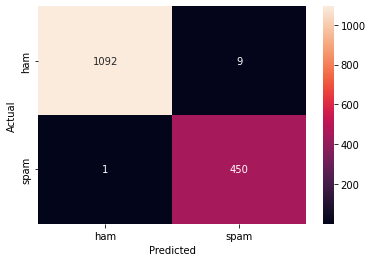

In [12]:
data = {'y_Actual':    y_test.values,
        'y_Predicted': y_pred
        }
d = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(d['y_Actual'], d['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True,fmt='d',xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.show()